https://mlwhiz.com/blog/2019/07/30/sampling/

In [1]:
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import TomekLinks

In [2]:
df = pd.read_csv("../data/autoscout24.csv")
df[:3]

,article_id,product_tier,make_name,price,first_zip_digit,created_date,deleted_date,search_views,detail_views,stock_days,ctr,live_days,car_age
0,350625839,Basic,Mitsubishi,16750,5,2018-07-24,2018-08-24,3091.0,123.0,30,0.037803,31,10
1,350266763,Basic,Ford,1750,6,2018-07-20,2018-10-29,1856.0,26.0,101,0.014009,101,20
2,361204569,Basic,Volkswagen,24890,6,2018-10-20,2018-10-22,125.0,6.0,2,0.048000,2,6


In [3]:
# Simple Random Sampling
sample_df = df.sample(100)
sample_df.head(3)

,article_id,product_tier,make_name,price,first_zip_digit,created_date,deleted_date,search_views,detail_views,stock_days,ctr,live_days,car_age
44379,360084882,Basic,Volvo,14900,5,2018-08-10,2018-11-10,145.0,9.0,3,0.062069,92,9
16651,364653806,Basic,Land Rover,13450,2,2018-11-28,2019-03-27,13483.0,905.0,119,0.067122,119,18
50363,347262151,Premium,Citroen,13945,2,2018-04-07,2018-08-28,5520.0,141.0,54,0.025543,143,11


In [21]:
# Stratified Sampling
y = df.price
X = df.drop(columns=["price"])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        stratify=pd.cut(y, 3, labels=["cheap", "medium", "expansive"]),
                                                        test_size=0.25)

In [20]:
y.count()
y_train

26208     1250
29244     9949
8608     13440
43252     1900
26578    22888
         ...  
49282    15950
24842    17200
8586      9900
35789    49500
53881     8750
Name: price, Length: 41118, dtype: int64

# Reservoir Sampling
Reservoir sampling is an algorithm for randomly selecting k samples from a population of unknown size n, where n is either very large or the elements are arriving in a stream. The key feature of this algorithm is that it only needs to store k items at any given time, regardless of how many items it has processed.

<details>

The algorithm uses O(k) space complexity, as it only needs to store k items at any given time.

The probability of selecting a new element decreases, but it's done in such a way that each element in the stream has an equal probability of being in the final reservoir, regardless of its position in the stream.

**How it Works**:

For the first k elements, we include them automatically. Their probability of being in the final sample is 1 at this point.For each subsequent element, we give it a k/(i+1) chance of replacing one of the existing elements.
If it does replace an element, it's now in the reservoir. If not, it's discarded.


**The Math Behind It**:

For any element after the kth position, its chance of getting into the reservoir at its turn is k/(i+1).
If it gets in, its chance of surviving subsequent rounds (not being kicked out) is i/(i+1) * (i+1)/(i+2) * ... * (n-1)/n.
If you multiply these probabilities together, you get k/n for every element!


**An Example**:

Let's say k=1 and we have a stream of 3 numbers.

The 1st number: 100% chance of being selected initially.
The 2nd number: 50% chance of replacing the 1st number.
The 3rd number: 33.3% chance of replacing whoever is there.

In the end, each number has a 1/3 chance of being the final selection.
Balancing Act:

Earlier elements have a higher chance of getting in initially, but also more chances to be kicked out.
Later elements have a lower chance of getting in, but if they do, they're less likely to be kicked out afterward.
These factors balance out to give each element an equal overall probability.
</details>

In [7]:
import random

def generator(max):
    number = 1
    while number < max:
        number += 1
        yield number

# Create as stream generator
stream = generator(10000)

# Doing Reservoir Sampling from the stream
k=5
reservoir = []
for i, element in enumerate(stream):
    if i+1<= k:
        # reservoir is filled with the first 5 elements
        reservoir.append(element) 
    else:
        # probability of every further element getting in the reservoir shrinks
        # but so is the change of getting kicked out of the reservoir. The two probabilities 
        # even out and every element has a k/n chance of staying in the reservoir.
        probability = k/(i+1)
        if random.random() < probability:
            # Select item in stream and remove one of the k items already selected
             reservoir[random.choice(range(0,k))] = element

print(reservoir)

[5985, 5643, 9973, 9514, 88]


# Random Undersampling and Oversampling

A widely adopted technique for dealing with highly imbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and/or adding more examples from the minority class (over-sampling).

In [8]:
#  create some example imbalanced data
from sklearn.datasets import make_classification

X, y = make_classification(
    n_classes=2, 
    class_sep=1.5, 
    weights=[0.9, 0.1],
    n_informative=3, 
    n_redundant=1, 
    flip_y=0,
    n_features=20, 
    n_clusters_per_class=1,
    n_samples=100, 
    random_state=10
)

X = pd.DataFrame(X)
X['target'] = y

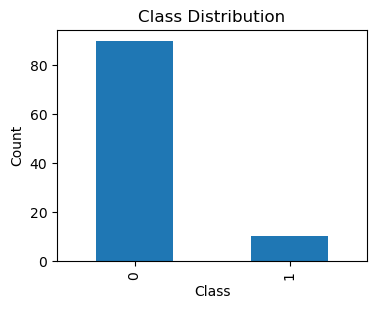

<Figure size 600x400 with 0 Axes>

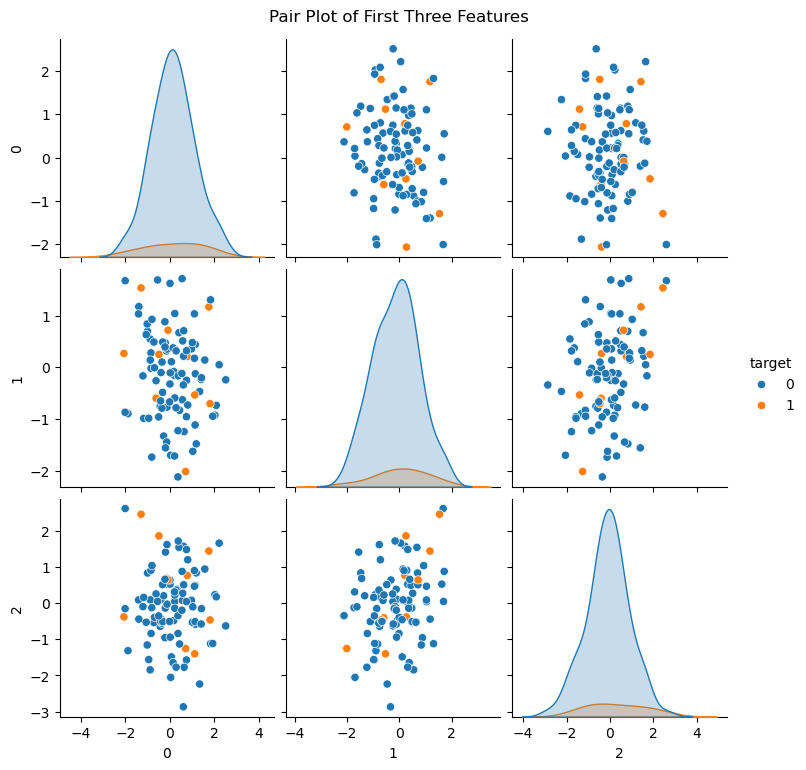

In [9]:
# Class distribution
plt.figure(figsize=(4, 3))
X['target'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Pair plot of first three features
plt.figure(figsize=(6, 4))
sns.pairplot(X.iloc[:, [0, 1, 2, -1]], hue='target')
plt.suptitle('Pair Plot of First Three Features', y=1.02)
plt.show()

In [23]:
num_0 = len(X[X['target']==0]) # no. of negatives
num_1 = len(X[X['target']==1]) # no. of positives
print(num_0,num_1)

# random undersample - sample only as many records as you have in the underrepresented class
undersampled_data = pd.concat([ X[X['target']==0].sample(num_1) , X[X['target']==1] ])
print(len(undersampled_data))

# random oversample - sample as many as you have in the overrepresented class, by replacing and resampling the underrep. class
oversampled_data = pd.concat([ X[X['target']==0] , X[X['target']==1].sample(num_0, replace=True) ])
print(len(oversampled_data))


90 10
20
180


# Undersampling and Oversampling 
using imbalanced-learn

imbalanced-learn(imblearn) is a Python Package to tackle of imbalanced datasets.

## Undersampling with Tomek links 

These are the pairs of opposite classes having close instances.

When the majority class instances are removed there gets to expand the space between both the classes that facilitate the classification process.



![image info](https://lh3.googleusercontent.com/hNRcwTksmr9k8crnJPqX7XKytGHKmM8bcyVvtVkgDQq8PWSG_6KXzzV7NlpjtFpt82YVNTRlYeEZsQkzKZsWBo4PN-pIVHZeyN0A9UVBDcE-FhBVWJzsoWsUuFUOqMNHOKP5KM3L)

<details>

These pairs are often found near the decision boundary between classes.

The algorithm identifies all Tomek Links and removes the instance of the majority class from each link.

This process effectively "cleans" the border between classes by removing majority class instances that are close to minority class instances.To clarify the decision boundary between classes.

To balance the dataset by selectively removing majority class instances. 

It can help reduce noise and improve classification accuracy. 

It can potentially remove important instances if the class overlap is significant.
</details>

In [24]:
# Ensure all column names are strings
if isinstance(X, pd.DataFrame):
    X.columns = X.columns.astype(str)

# Create and apply the TomekLinks undersampler
tl = TomekLinks(sampling_strategy='majority') # resample only the majority class;
X_resampled, y_resampled = tl.fit_resample(X, y)

# If X was originally a DataFrame, convert the result back to a DataFrame
if isinstance(X, pd.DataFrame):
    X_resampled = pd.DataFrame(X_resampled, columns=X.columns)

print(f"Original shape: {X.shape}")
print(f"Resampled shape: {X_resampled.shape}")
print(f"Number of samples removed: {X.shape[0] - X_resampled.shape[0]}")

Original shape: (100, 21)
Resampled shape: (99, 21)
Number of samples removed: 1


In [21]:
X_resampled.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,target
0,0.327419,-0.123936,0.377707,-0.650123,0.267562,1.228781,2.208772,-0.185977,0.238732,-2.565438,...,0.644056,0.104375,-1.703024,-0.510083,-0.108812,-0.230132,1.553707,1.497538,-1.476485,0
1,-0.204642,0.472155,-0.140616,-2.902493,-1.513665,1.149545,2.283673,-0.809117,-1.723535,-0.958556,...,-0.279701,-1.431391,0.260146,-0.501306,-2.320545,0.422214,1.386474,-0.073335,0.586859,0
2,0.208274,-0.156982,0.063369,-0.545759,-0.395416,-2.679969,1.507772,0.391485,-0.487337,-0.946147,...,-1.011854,-1.124795,0.347291,-1.078836,0.046923,-0.978324,1.100517,-0.697134,0.339577,0
3,0.785568,0.208472,0.760082,-0.046130,0.310844,-0.403927,1.462897,0.962173,-0.520996,1.647360,...,0.316792,-0.261528,-1.260698,0.822700,0.141031,-0.294805,2.216364,-1.129875,-1.059984,1
4,-0.886195,0.548814,-1.844824,0.638066,0.023932,0.491861,0.722346,0.811078,-0.468527,0.035382,...,-0.751144,0.148616,-0.185694,2.102140,-0.166839,0.088302,0.632036,1.766467,-1.373949,0


# Oversampling with SMOTE

Synthetic Minority oversampling technique (SMOTE)

- Based on the elements that are already present it consists of synthesizing elements.
- It works by computing KNN for the randomly chosen point from the minority class.
- Between the chosen point and its neighbors, synthetic points are added.


In [28]:
from imblearn.over_sampling import SMOTE
from collections import Counter

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))
# X_res.head()

Resampled dataset shape Counter({np.int64(0): 90, np.int64(1): 90})
